# Sarcasm: sentiment analysis of news headlines

#### We develop a model that predicts if sarcasm is present in news headlines.

We load the dataset and explore some of its statistics.

In [1]:
import json
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import urllib.request
import zipfile

In [2]:
data = pd.read_json('sarcasm.json', lines=True)
data = shuffle(data)
data.head()

,article_link,headline,is_sarcastic
54147,https://www.theonion.com/irish-wake-a-blur-181...,irish wake a blur,1
5380,https://www.theonion.com/queen-elizabeth-frant...,queen elizabeth frantically trying to preserve...,1
54825,https://local.theonion.com/dad-can-t-believe-l...,dad can't believe lawn didn't get him anything...,1
25315,https://www.huffingtonpost.com/entry/the-sec-c...,"the sec, cftc and the real-time risks in today...",0
52063,https://politics.theonion.com/nation-finds-sol...,nation finds solace in knowledge candidates ta...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 54147 to 50238
Data columns (total 3 columns):
article_link    55328 non-null object
headline        55328 non-null object
is_sarcastic    55328 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [4]:
data.describe()

,is_sarcastic
count,55328.000000
mean,0.458321
std,0.498264
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
headlines = data.loc[:,'headline'].values
is_sarcastic = data.loc[:,'is_sarcastic'].values

(array([29970.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 25358.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

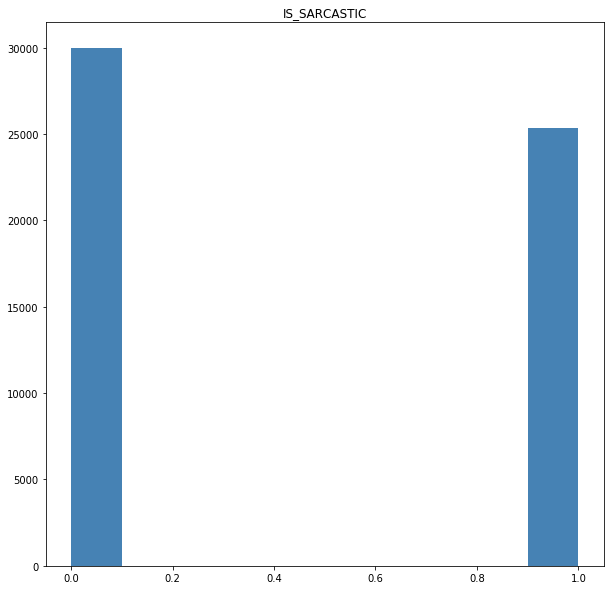

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('IS_SARCASTIC')
ax.hist(is_sarcastic, histtype='stepfilled', color='steelblue', edgecolor='none')

In [7]:
np.sum(is_sarcastic)*100/len(is_sarcastic)

45.83212839791787

We see that the dataset is a bit unbalanced so it would be helpful to plot a confusion matrix for each model in order to asses its performance.

-----

Here we define some hyperparameters and we construct the datasets for training and testing. 

In [8]:
stops_words = set(stopwords.words('english'))

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()

In [10]:
def nlp_preprocess(sentence):
    sentence_ = ''
    for word in sentence.split(' '):
        word_lower = word.lower()
        if word_lower not in stops_words:
            word_lemmatized = wordnet_lemmatizer.lemmatize(word_lower)
            word_reg = re.sub(r"[^A-Za-z]+", '', word_lemmatized)
            sentence_ = sentence_ + word_reg + ' '
    return sentence_[:-1]

In [11]:
headlines_ = []
for headline in headlines:
    headline_ = nlp_preprocess(headline)
    headlines_.append(headline_)

In [12]:
vocab_size = 10000
max_length = 50
filters='''!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'''
oov_tok = "<OOV>"
trunc_type ='post'
padding_type ='post'
training_size = 80*len(data)//100

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                                  lower=True,
                                                  split=' ',
                                                  char_level=False,
                                                  oov_token=oov_tok,
                                                  filters=filters)
tokenizer.fit_on_texts(headlines_[:training_size])

In [14]:
sequences_train = tokenizer.texts_to_sequences(headlines_[:training_size])
padded_sequences_train = tf.keras.preprocessing.sequence.pad_sequences(sequences=sequences_train,
                                                                       maxlen=max_length,
                                                                       dtype='int32',
                                                                       padding=padding_type,
                                                                       truncating=trunc_type,
                                                                       value=0)

X_train = np.array(padded_sequences_train)
Y_train = np.reshape(np.array(is_sarcastic[:training_size]), newshape=(-1, 1))

In [15]:
sequences_test = tokenizer.texts_to_sequences(headlines_[training_size:])
padded_sequences_test = tf.keras.preprocessing.sequence.pad_sequences(sequences=sequences_test,
                                                                      maxlen=max_length,
                                                                      dtype='int32',
                                                                      padding=padding_type,
                                                                      truncating=trunc_type,
                                                                      value=0)

X_val = np.array(padded_sequences_test)
Y_val = np.reshape(np.array(is_sarcastic[training_size:]), newshape=(-1, 1))

In [16]:
X_train.shape, Y_train.shape, X_val.shape, X_val.shape

((44262, 50), (44262, 1), (11066, 50), (11066, 50))

-----

Here we visualize the word frequencies of our dictionary created in the last step via a word cloud.

In [17]:
word_freq = dict(tokenizer.word_counts)

In [18]:
sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:50]

[('new', 2547),
 ('trump', 2101),
 ('man', 2091),
 ('woman', 1240),
 ('say', 1092),
 ('report', 1032),
 ('get', 969),
 ('one', 902),
 ('day', 849),
 ('make', 829),
 ('time', 816),
 ('us', 808),
 ('american', 793),
 ('area', 789),
 ('year', 770),
 ('donald', 733),
 ('like', 712),
 ('life', 692),
 ('first', 664),
 ('way', 638),
 ('trumps', 632),
 ('people', 628),
 ('house', 605),
 ('show', 582),
 ('obama', 578),
 ('thing', 565),
 ('take', 556),
 ('white', 556),
 ('find', 552),
 ('back', 549),
 ('still', 546),
 ('clinton', 514),
 ('want', 509),
 ('family', 508),
 ('could', 479),
 ('know', 466),
 ('world', 465),
 ('state', 465),
 ('call', 451),
 ('school', 449),
 ('right', 445),
 ('child', 439),
 ('need', 436),
 ('study', 432),
 ('bill', 416),
 ('black', 416),
 ('would', 407),
 ('home', 406),
 ('love', 402),
 ('gop', 400)]

In [19]:
wordcloud = WordCloud(width=1920,
                      height=1920, 
                      mask=None,
                      max_font_size=500,
                      colormap='viridis',
                      max_words=200)

wordcloud.fit_words(word_freq)

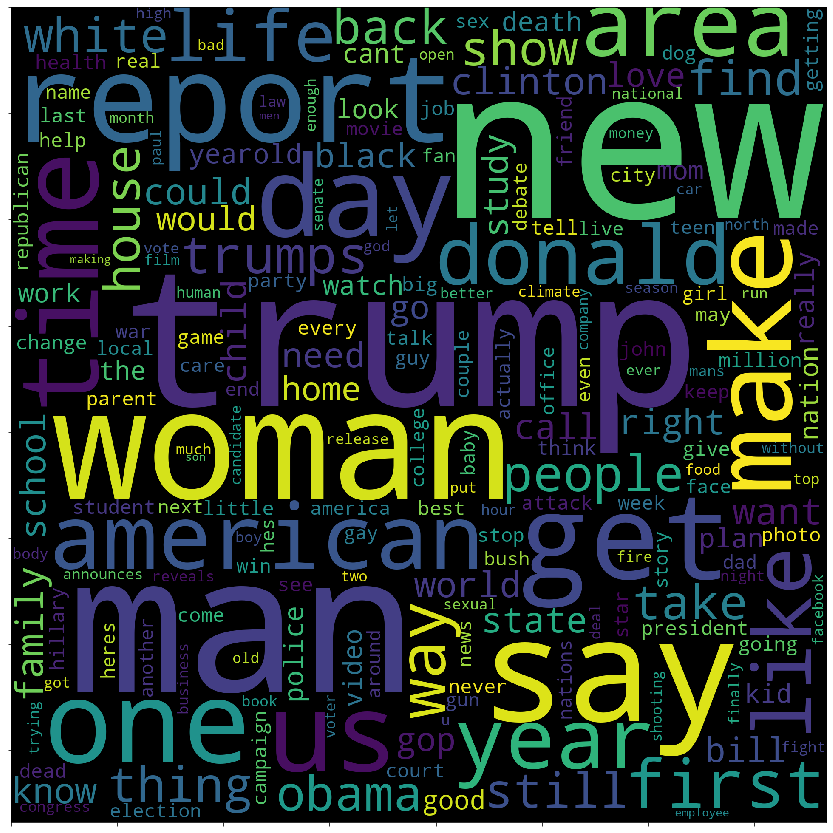

In [20]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.imshow(wordcloud)

-----

This function plots the confusion matrix of the model predictions.

In [21]:
def plot_confusion_matrix(model):    
    cm = confusion_matrix(Y_val.flatten(), model.predict(X_val).flatten()>0.5, labels=[1.,0.])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_xticklabels(2*['']+['Positive']+3*['']+['Negative']+2*[''])
    ax.set_yticklabels(2*['']+['Positive']+3*['']+['Negative']+2*[''])
    ax.text(0., 0., str(cm[0,0]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(1., 0., str(cm[0,1]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(0., 1., str(cm[1,0]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(1., 1., str(cm[1,1]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.imshow(cm)

This function shows the training history of the model to see how is performing in every step.

In [22]:
def plot_training(model):
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    accuracy = model.history.history['binary_accuracy']
    val_accuracy = model.history.history['val_binary_accuracy']
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title('LOSS')
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('loss')
    ax1.plot(loss, marker='.', color='#FF00AE', markersize=1, linestyle='-', label='train')
    ax1.plot(val_loss, marker='.', color='#0F00FF', markersize=1, linestyle='-', label='val')
    ax1.legend()
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title('ACCURACY')
    ax2.set_xlabel('iterations')
    ax2.set_ylabel('accuracy')
    ax2.plot(accuracy, marker='.', color='#FF00AE', markersize=1, linestyle='-', label='train')
    ax2.plot(val_accuracy, marker='.', color='#0F00FF', markersize=1, linestyle='-', label='val')
    ax2.legend()

-----

Here we train our first model and evaluate its performance.

In [23]:
def Model_1():
    model = tf.keras.Sequential([        
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=16,
                                  input_length=X_train.shape[1]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, 
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=16, 
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=Y_train.shape[1], 
                              activation='sigmoid',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                     patience=10,
                                                     min_delta=0.001,
                                                     factor=0.1,
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=20,
                                                 min_delta=0.001)
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)
    model.summary()
    model.fit(X_train, Y_train, epochs=100, batch_size=32, callbacks=[callback1, callback2], validation_data=(X_val, Y_val))
    return model

In [24]:
model_1 = Model_1()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

44262/44262 [==============================] - 2s 55us/sample - loss: 0.0026 - binary_accuracy: 0.9993 - val_loss: 1.6815 - val_binary_accuracy: 0.9463
Epoch 43/100
44262/44262 [==============================] - 3s 58us/sample - loss: 0.0031 - binary_accuracy: 0.9992 - val_loss: 1.6739 - val_binary_accuracy: 0.9461
Epoch 44/100
44262/44262 [==============================] - 3s 60us/sample - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 1.6309 - val_binary_accuracy: 0.9463
Epoch 45/100
44262/44262 [==============================] - 3s 57us/sample - loss: 0.0022 - binary_accuracy: 0.9993 - val_loss: 1.6524 - val_binary_accuracy: 0.9468
Epoch 46/100
44262/44262 [==============================] - 3s 60us/sample - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 1.6156 - val_binary_accuracy: 0.9470
Epoch 47/100
44262/44262 [==============================] - 3s 57us/sample - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 1.6057 - val_binary_accuracy: 0.9468
Epoch 48/100
44262/4426

In [25]:
model_1.evaluate(X_train, Y_train)

44262/44262 [==============================] - 1s 19us/sample - loss: 6.1827e-04 - binary_accuracy: 0.9996


[0.0006182736356235895, 0.9996385]

In [26]:
model_1.evaluate(X_val, Y_val)

11066/11066 [==============================] - 0s 20us/sample - loss: 1.7337 - binary_accuracy: 0.9469


[1.7337038075257034, 0.94686425]

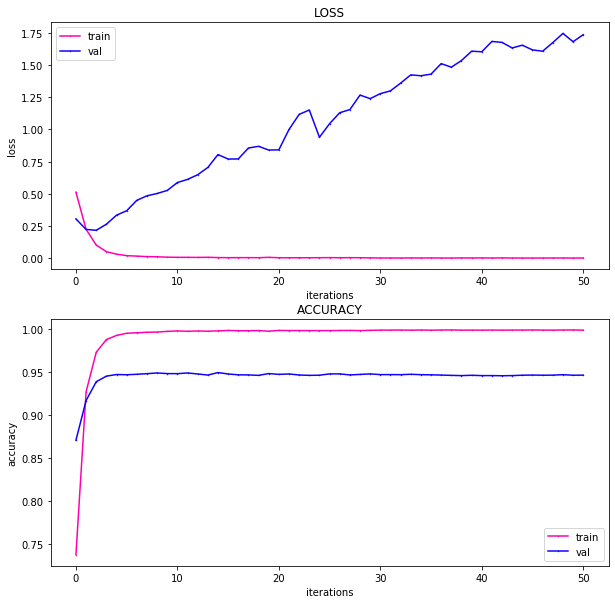

In [27]:
plot_training(model_1)

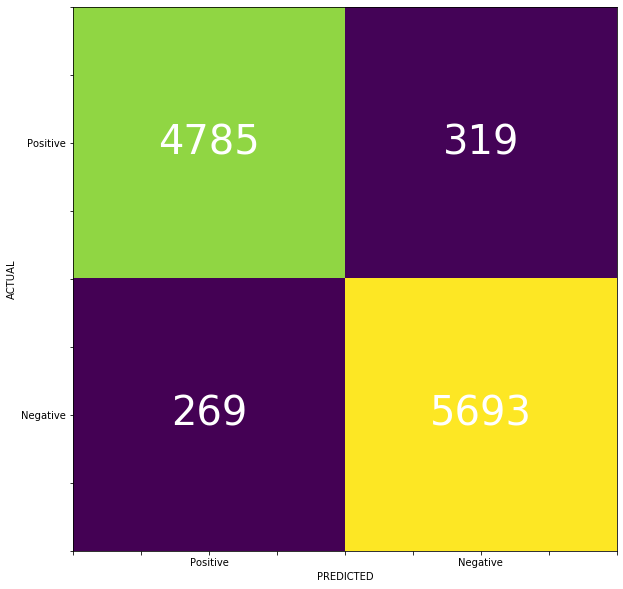

In [28]:
plot_confusion_matrix(model_1)

We see that this model is performing quite well but it is a bit overfitting so we keep trying with other architectures.

-----

Here we train our second model and evaluate its performance.

In [29]:
def Model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=64,
                                  input_length=X_train.shape[1]),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(units=64, 
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=32, 
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=16, 
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=8, 
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=Y_train.shape[1], 
                              activation='sigmoid',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                     patience=10,
                                                     min_delta=0.001,
                                                     factor=0.1,
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=20,
                                                 min_delta=0.001)
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)
    model.summary()
    model.fit(X_train, Y_train, epochs=100, batch_size=32, callbacks=[callback1, callback2], validation_data=(X_val, Y_val))
    return model

In [30]:
model_2 = Model_2()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            640000    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

44262/44262 [==============================] - 5s 112us/sample - loss: 0.0466 - binary_accuracy: 0.9701 - val_loss: 2.3656 - val_binary_accuracy: 0.9512
Epoch 40/100
44262/44262 [==============================] - 5s 113us/sample - loss: 0.0466 - binary_accuracy: 0.9705 - val_loss: 2.4625 - val_binary_accuracy: 0.9521
Epoch 41/100
44262/44262 [==============================] - 5s 109us/sample - loss: 0.0466 - binary_accuracy: 0.9698 - val_loss: 2.5995 - val_binary_accuracy: 0.9516
Epoch 42/100
44262/44262 [==============================] - 5s 108us/sample - loss: 0.0450 - binary_accuracy: 0.9704 - val_loss: 2.7285 - val_binary_accuracy: 0.9515
Epoch 43/100
44262/44262 [==============================] - 5s 107us/sample - loss: 0.0467 - binary_accuracy: 0.9698 - val_loss: 2.7423 - val_binary_accuracy: 0.9521
Epoch 44/100
44262/44262 [==============================] - 5s 110us/sample - loss: 0.0462 - binary_accuracy: 0.9707 - val_loss: 2.7863 - val_binary_accuracy: 0.9522
Epoch 45/100
4426

In [31]:
model_2.evaluate(X_train, Y_train)

44262/44262 [==============================] - 1s 22us/sample - loss: 8.3724e-04 - binary_accuracy: 0.9995


[0.0008372424872222871, 0.99950296]

In [32]:
model_2.evaluate(X_val, Y_val)

11066/11066 [==============================] - 0s 23us/sample - loss: 3.0681 - binary_accuracy: 0.9525


[3.068108115687003, 0.952467]

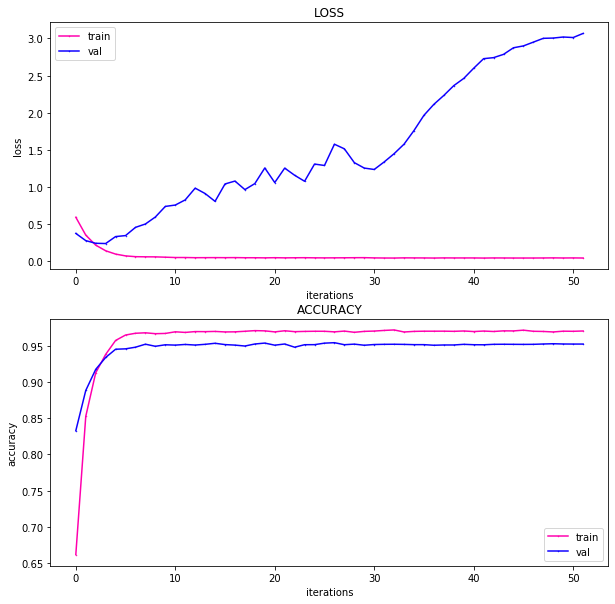

In [33]:
plot_training(model_2)

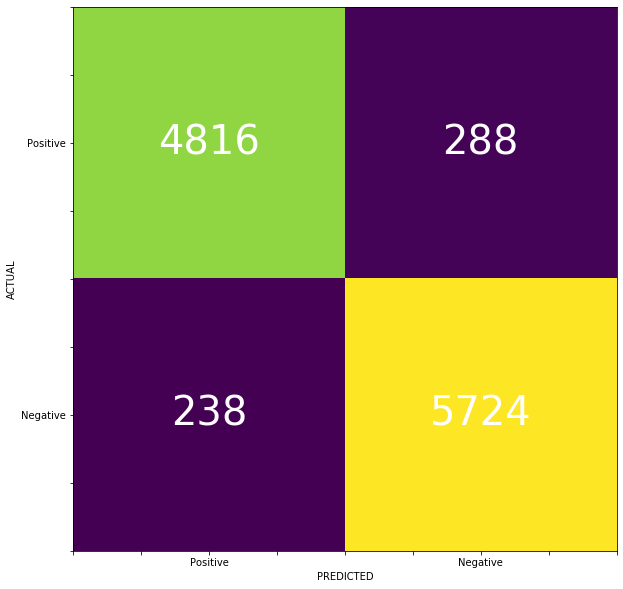

In [34]:
plot_confusion_matrix(model_2)

This model is also performing quite well but it is a bit overfitting. We keep trying with other architectures.

-----

Here we train our third model and evaluate its performance.

In [35]:
def Model_3():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=64,
                                  input_length=X_train.shape[1]),
        tf.keras.layers.Conv1D(filters=128,
                               kernel_size=3,
                               strides=1,
                               padding='valid',
                               activation='relu',
                               kernel_initializer='glorot_uniform',
                               bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,
                                                           activation='tanh',
                                                           recurrent_activation='sigmoid',
                                                           kernel_initializer='glorot_uniform',
                                                           bias_initializer='zeros',
                                                           recurrent_initializer='zeros',
                                                           return_sequences=False,
                                                           return_state=False),
                                      merge_mode='concat'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=Y_train.shape[1], 
                              activation='sigmoid',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                     patience=10,
                                                     min_delta=0.001,
                                                     factor=0.1,
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=20,
                                                 min_delta=0.001)
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)
    model.summary()
    model.fit(X_train, Y_train, epochs=100, batch_size=32, callbacks=[callback1, callback2], validation_data=(X_val, Y_val))
    return model

In [36]:
model_3 = Model_3()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 128)           24704     
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 763,649
Trainable params: 763,649
Non-trainable params: 0
________________________________________________

44262/44262 [==============================] - 50s 1ms/sample - loss: 7.1218e-04 - binary_accuracy: 0.9996 - val_loss: 0.5635 - val_binary_accuracy: 0.9497
Epoch 44/100
44262/44262 [==============================] - 50s 1ms/sample - loss: 8.1904e-04 - binary_accuracy: 0.9996 - val_loss: 0.5692 - val_binary_accuracy: 0.9493
Epoch 45/100
44262/44262 [==============================] - 50s 1ms/sample - loss: 7.2667e-04 - binary_accuracy: 0.9996 - val_loss: 0.5718 - val_binary_accuracy: 0.9490
Epoch 46/100
44262/44262 [==============================] - 50s 1ms/sample - loss: 7.5043e-04 - binary_accuracy: 0.9996 - val_loss: 0.5785 - val_binary_accuracy: 0.9487
Epoch 47/100
44262/44262 [==============================] - 50s 1ms/sample - loss: 6.8987e-04 - binary_accuracy: 0.9996 - val_loss: 0.5838 - val_binary_accuracy: 0.9490
Epoch 48/100
44262/44262 [==============================] - 50s 1ms/sample - loss: 7.1127e-04 - binary_accuracy: 0.9996 - val_loss: 0.5796 - val_binary_accuracy: 0.9494

In [37]:
model_3.evaluate(X_train, Y_train)

44262/44262 [==============================] - 9s 206us/sample - loss: 6.5484e-04 - binary_accuracy: 0.9996


[0.0006548378996660205, 0.9996385]

In [38]:
model_3.evaluate(X_val, Y_val)

11066/11066 [==============================] - 2s 191us/sample - loss: 0.6028 - binary_accuracy: 0.9495


[0.6027836554302891, 0.9494849]

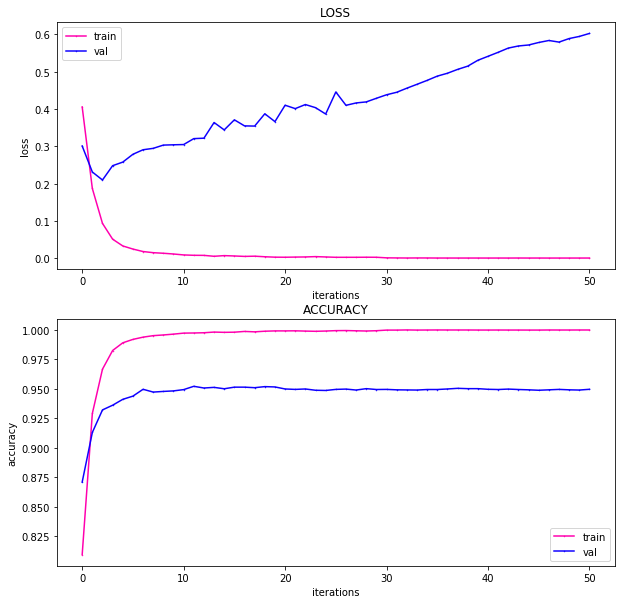

In [39]:
plot_training(model_3)

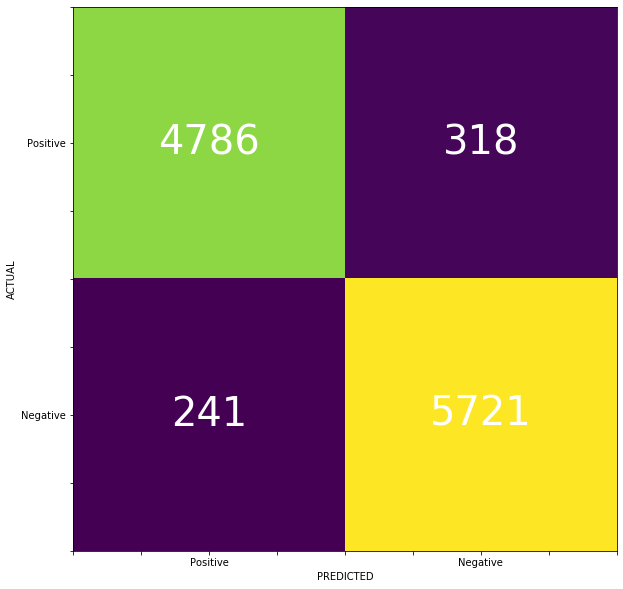

In [40]:
plot_confusion_matrix(model_3)

This model is performing a bit better than the last one. We keep trying with other architectures.

-----

Here we train our fourth model. We will use some pretrained embeddings in an attempt to enhance performance.

In [41]:
url = 'https://firebasestorage.googleapis.com/v0/b/z2tma61d2a74hya815w9x621uszb3a.appspot.com/o/glove.6B.100d.txt.zip?alt=media&token=df3a863b-bea5-4e6f-a97b-ae0a69fbf053'
local_zip = 'glove.6B.100d.txt.zip'
urllib.request.urlretrieve(url, local_zip)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [42]:
with open('glove.6B.100d.txt', 'r') as f:
    word_to_vec = {}
    for line in f:
        values = line.strip().split()
        curr_word = values[0]
        word_to_vec[curr_word] = np.array(values[1:], dtype='float32')
        
embedding_matrix = np.zeros(shape=(vocab_size, 100), dtype='float32')
keys = list(tokenizer.word_index.keys())
values = tokenizer.texts_to_sequences(list(tokenizer.word_index.keys()))
for i in range(len(tokenizer.word_index)):
    word = keys[i]
    idx = values[i]
    if word in word_to_vec:
        vec = word_to_vec[word]
        embedding_matrix[idx, :] = vec

In [43]:
def Model_4():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                  output_dim=embedding_matrix.shape[1],
                                  input_length=X_train.shape[1]),
        tf.keras.layers.Conv1D(filters=256,
                               kernel_size=3,
                               strides=1,
                               padding='valid',
                               activation='relu',
                               kernel_initializer='glorot_uniform',
                               bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,
                                                           activation='tanh',
                                                           recurrent_activation='sigmoid',
                                                           kernel_initializer='glorot_uniform',
                                                           bias_initializer='zeros',
                                                           recurrent_initializer='zeros',
                                                           return_sequences=False,
                                                           return_state=False),
                                      merge_mode='concat'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=128,
                              activation='relu',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=Y_train.shape[1],
                              activation='sigmoid',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros')
    ])
    model.layers[0].trainable = False
    model.layers[0].set_weights([embedding_matrix])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                     patience=10,
                                                     min_delta=0.001,
                                                     factor=0.1,
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=20,
                                                 min_delta=0.001)
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)
    model.summary()
    model.fit(X_train, Y_train, epochs=100, batch_size=32, callbacks=[callback1, callback2], validation_data=(X_val, Y_val))
    return model

In [44]:
model_4 = Model_4()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 256)           77056     
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

44262/44262 [==============================] - 99s 2ms/sample - loss: 0.1031 - binary_accuracy: 0.9617 - val_loss: 0.1676 - val_binary_accuracy: 0.9477
Epoch 42/100
44262/44262 [==============================] - 98s 2ms/sample - loss: 0.1015 - binary_accuracy: 0.9632 - val_loss: 0.1662 - val_binary_accuracy: 0.9533
Epoch 43/100
44262/44262 [==============================] - 99s 2ms/sample - loss: 0.0966 - binary_accuracy: 0.9637 - val_loss: 0.1733 - val_binary_accuracy: 0.9533
Epoch 44/100
44262/44262 [==============================] - 100s 2ms/sample - loss: 0.0988 - binary_accuracy: 0.9637 - val_loss: 0.1615 - val_binary_accuracy: 0.9536
Epoch 45/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0961 - binary_accuracy: 0.9646 - val_loss: 0.1637 - val_binary_accuracy: 0.9535
Epoch 46/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0989 - binary_accuracy: 0.9639 - val_loss: 0.1835 - val_binary_accuracy: 0.9470
Epoch 47/100
44262/442

44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0751 - binary_accuracy: 0.9732 - val_loss: 0.2062 - val_binary_accuracy: 0.9557
Epoch 91/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0772 - binary_accuracy: 0.9731 - val_loss: 0.1884 - val_binary_accuracy: 0.9554
Epoch 92/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0740 - binary_accuracy: 0.9734 - val_loss: 0.1792 - val_binary_accuracy: 0.9540
Epoch 93/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0747 - binary_accuracy: 0.9740 - val_loss: 0.1849 - val_binary_accuracy: 0.9539
Epoch 94/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0749 - binary_accuracy: 0.9736 - val_loss: 0.1840 - val_binary_accuracy: 0.9534
Epoch 95/100
44262/44262 [==============================] - 96s 2ms/sample - loss: 0.0727 - binary_accuracy: 0.9736 - val_loss: 0.1993 - val_binary_accuracy: 0.9552
Epoch 96/100
44262/4426

In [45]:
model_4.evaluate(X_train, Y_train)

44262/44262 [==============================] - 25s 574us/sample - loss: 0.0026 - binary_accuracy: 0.9995


[0.002563861348606202, 0.99954814]

In [46]:
model_4.evaluate(X_val, Y_val)

11066/11066 [==============================] - 6s 542us/sample - loss: 0.1933 - binary_accuracy: 0.9560


[0.1933412130110938, 0.9559913]

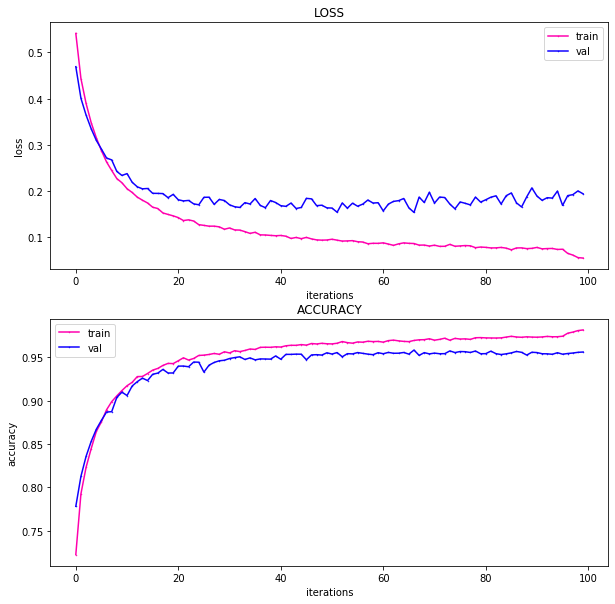

In [47]:
plot_training(model_4)

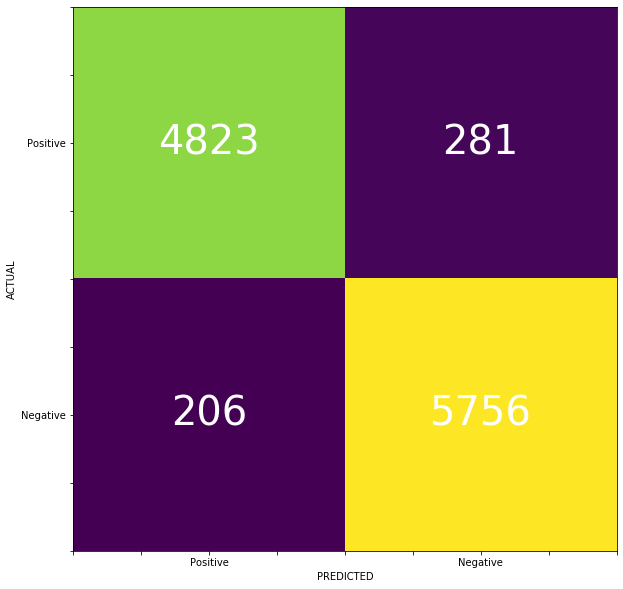

In [48]:
plot_confusion_matrix(model_4)

#### We see that the last model is the best one. Some overfitting is present but it could be considered negligible. Additional exploration of hyperparameters would be necessary to make a final conclusion. But this performance enhance over the other models is at expense of a higher number of parameters and longer training time. 